# Regression Analysis: Subcategory Scores → Overall Score

This notebook analyzes how subcategory scores (from VLM responses) correlate with and can predict the overall property condition score.

We'll:
1. Load VLM scoring results with subcategory scores
2. Analyze correlations between subcategories and overall score
3. Train regression models to predict overall score from subcategories
4. Visualize feature importance and predictions


In [35]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
from src.config import Config

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [36]:
def extract_subcategory_scores(response):
    """Extract subcategory scores from VLM JSON response"""
    if not response:
        return {}
    
    try:
        # Clean response
        clean_response = response.strip()
        if "```json" in clean_response:
            clean_response = clean_response.split("```json")[1].split("```")[0].strip()
        elif "```" in clean_response:
            clean_response = clean_response.split("```")[1].split("```")[0].strip()
        
        parsed = json.loads(clean_response)
        
        # Extract subcategory scores
        subscores = {}
        if 'subscores' in parsed:
            for category, data in parsed['subscores'].items():
                if isinstance(data, dict) and 'score' in data:
                    subscores[category] = data['score']
                elif isinstance(data, (int, float)):
                    subscores[category] = data
        
        return subscores
    except:
        return {}

# Load VLM scoring results from JSON (has complete responses)
output_dir = Config.OUTPUTS_DIR
results_file = os.path.join(output_dir, "regression_data.json")

all_results = []
if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        data = json.load(f)
    results_df = pd.DataFrame(data)
    print(f"✅ Loaded {len(results_df)} results from {os.path.basename(results_file)}")
else:
    print(f"❌ File not found: {results_file}")
    results_df = pd.DataFrame()

if len(results_df) > 0:
    print(f"📊 Total results: {len(results_df)}")

✅ Loaded 30 results from regression_data.json
📊 Total results: 30


In [37]:
# Extract subcategory scores from VLM responses
if len(results_df) > 0 and 'raw_response' in results_df.columns:
    subcategory_data = []
    
    for idx, row in results_df.iterrows():
        if pd.notna(row.get('raw_response')):
            subscores = extract_subcategory_scores(row['raw_response'])
            
            if subscores:
                record = {
                    'image_path': row.get('image_path'),
                    'expert_score': row.get('expert_score'),
                    'predicted_score': row.get('predicted_score'),
                }
                record.update(subscores)
                subcategory_data.append(record)
    
    subcat_df = pd.DataFrame(subcategory_data)
    
    if len(subcat_df) > 0:
        print(f"✅ Extracted subcategory scores from {len(subcat_df)} responses")
        print(f"\n📊 Subcategories found:")
        subcat_cols = [c for c in subcat_df.columns if c not in ['image_path', 'expert_score', 'predicted_score']]
        print(subcat_cols)
        display(subcat_df.head())
    else:
        print("⚠️  No subcategory scores found in responses")
        subcat_df = pd.DataFrame()
else:
    print("⚠️  No results with raw_response column found")
    subcat_df = pd.DataFrame()


✅ Extracted subcategory scores from 30 responses

📊 Subcategories found:
['general_exterior_condition', 'porch_entryway', 'landscaping', 'roof_gutters_downspouts', 'windows', 'extra_personal_touches']


,image_path,expert_score,predicted_score,general_exterior_condition,porch_entryway,landscaping,roof_gutters_downspouts,windows,extra_personal_touches
0,/home/exouser/DSM-property-condition-assessmen...,2.0,None,4,4,3,4,4,3
1,/home/exouser/DSM-property-condition-assessmen...,1.0,None,1,2,3,1,1,3
2,/home/exouser/DSM-property-condition-assessmen...,2.0,None,1,1,2,1,1,2
3,/home/exouser/DSM-property-condition-assessmen...,2.0,None,4,5,3,4,5,4
4,/home/exouser/DSM-property-condition-assessmen...,2.0,None,4,4,3,4,4,3


📊 Subcategory Correlations with Expert Score:


,subcategory,correlation,samples
0,general_exterior_condition,0.278207,30
2,landscaping,0.244407,30
3,roof_gutters_downspouts,0.195264,30
4,windows,0.138453,30
1,porch_entryway,-0.004772,30
5,extra_personal_touches,-0.323323,30


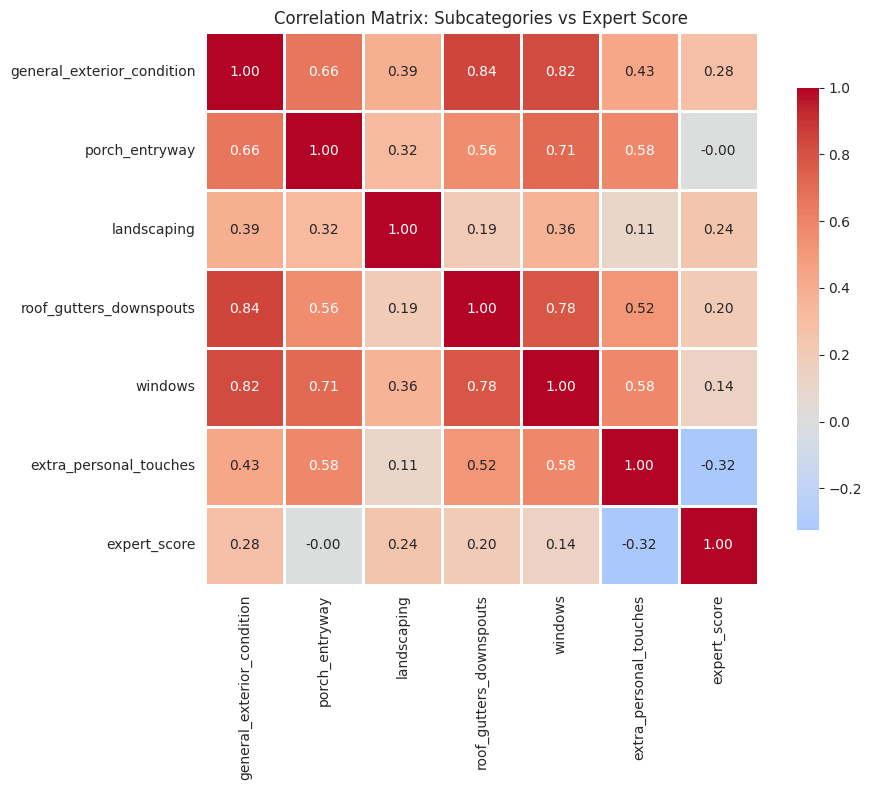

In [38]:
# Correlation analysis
if len(subcat_df) > 0 and 'expert_score' in subcat_df.columns:
    subcat_cols = [c for c in subcat_df.columns if c not in ['image_path', 'expert_score', 'predicted_score']]
    
    if len(subcat_cols) > 0:
        # Calculate correlations
        correlation_data = []
        for col in subcat_cols:
            if subcat_df[col].notna().sum() > 0:
                corr = subcat_df[col].corr(subcat_df['expert_score'])
                correlation_data.append({
                    'subcategory': col,
                    'correlation': corr,
                    'samples': subcat_df[col].notna().sum()
                })
        
        corr_df = pd.DataFrame(correlation_data).sort_values('correlation', ascending=False)
        
        print("📊 Subcategory Correlations with Expert Score:")
        display(corr_df)
        
        # Visualize correlation heatmap
        if len(subcat_cols) > 1:
            corr_matrix = subcat_df[subcat_cols + ['expert_score']].corr()
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                       square=True, linewidths=1, cbar_kws={"shrink": 0.8})
            plt.title('Correlation Matrix: Subcategories vs Expert Score')
            plt.tight_layout()
            plt.show()
    else:
        print("⚠️  No subcategory columns found")
else:
    print("⚠️  Cannot perform correlation analysis - missing data")


In [39]:
# Prepare data for regression
if len(subcat_df) > 0 and 'expert_score' in subcat_df.columns:
    subcat_cols = [c for c in subcat_df.columns if c not in ['image_path', 'expert_score', 'predicted_score']]
    
    # Filter to rows with all subcategories and expert score
    regression_df = subcat_df[subcat_cols + ['expert_score']].dropna()
    
    if len(regression_df) > 0:
        X = regression_df[subcat_cols]
        y = regression_df['expert_score']
        
        print(f"✅ Prepared {len(regression_df)} samples for regression")
        print(f"📊 Features: {list(X.columns)}")
        print(f"📊 Target distribution:")
        print(y.value_counts().sort_index())
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print(f"\n📊 Train: {len(X_train)}, Test: {len(X_test)}")
    else:
        print("⚠️  No complete samples for regression")
        X_train, X_test, y_train, y_test = None, None, None, None
else:
    print("⚠️  Cannot prepare regression data")
    X_train, X_test, y_train, y_test = None, None, None, None


✅ Prepared 30 samples for regression
📊 Features: ['general_exterior_condition', 'porch_entryway', 'landscaping', 'roof_gutters_downspouts', 'windows', 'extra_personal_touches']
📊 Target distribution:
expert_score
1.0     2
2.0    12
3.0    10
4.0     5
5.0     1
Name: count, dtype: int64

📊 Train: 24, Test: 6


In [40]:
# Train regression models
if X_train is not None:
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
    }
    
    results = {}
    
    for name, model in models.items():
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Evaluate
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        results[name] = {
            'model': model,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'y_test_pred': y_test_pred
        }
        
        print(f"\n{name}:")
        print(f"  Train R²: {train_r2:.3f}, Test R²: {test_r2:.3f}")
        print(f"  Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}")
    
    # Compare models
    comparison_df = pd.DataFrame({
        name: {
            'Test R²': res['test_r2'],
            'Test MAE': res['test_mae'],
            'Test MSE': res['test_mse']
        }
        for name, res in results.items()
    }).T
    
    print("\n📊 Model Comparison:")
    display(comparison_df)
else:
    print("⚠️  Cannot train models - missing data")
    results = {}



Linear Regression:
  Train R²: 0.359, Test R²: 0.117
  Train MAE: 0.658, Test MAE: 0.747

Ridge Regression:
  Train R²: 0.356, Test R²: 0.161
  Train MAE: 0.664, Test MAE: 0.724

Random Forest:
  Train R²: 0.824, Test R²: 0.162
  Train MAE: 0.266, Test MAE: 0.590

📊 Model Comparison:


,Test R²,Test MAE,Test MSE
Linear Regression,0.117009,0.747410,0.711298
Ridge Regression,0.160529,0.723571,0.676240
Random Forest,0.162324,0.590463,0.674795


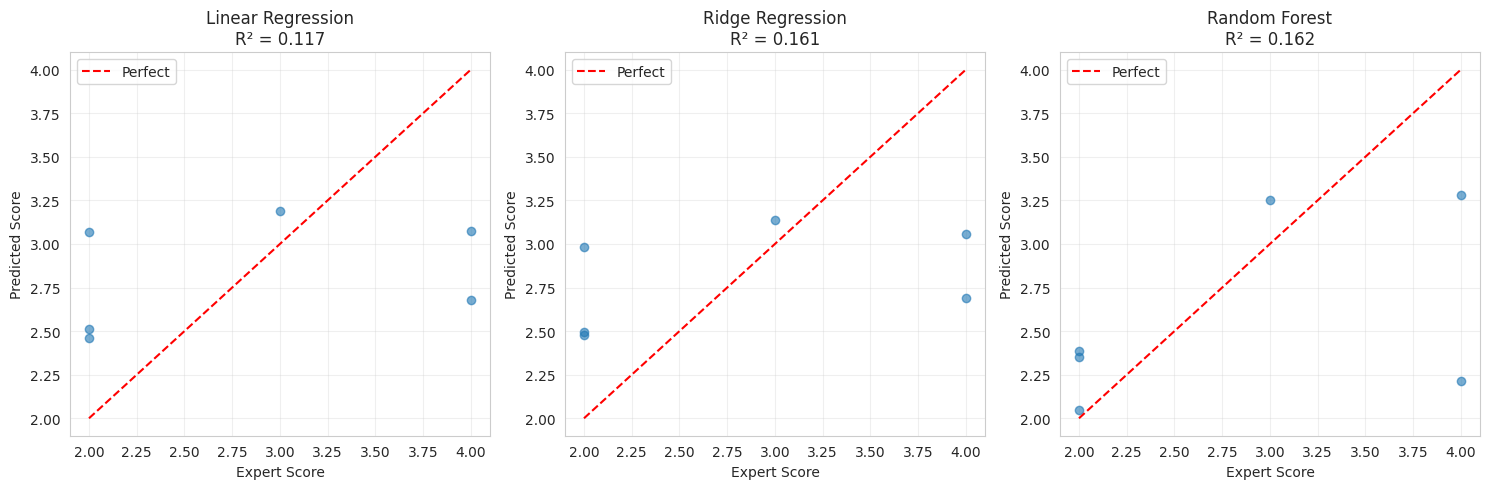

In [41]:
# Visualize predictions
if results and X_test is not None:
    fig, axes = plt.subplots(1, len(results), figsize=(5*len(results), 5))
    if len(results) == 1:
        axes = [axes]
    
    for idx, (name, res) in enumerate(results.items()):
        axes[idx].scatter(y_test, res['y_test_pred'], alpha=0.6)
        axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect')
        axes[idx].set_xlabel('Expert Score')
        axes[idx].set_ylabel('Predicted Score')
        axes[idx].set_title(f'{name}\nR² = {res["test_r2"]:.3f}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


📊 Feature Importance (Random Forest):


,feature,importance
5,extra_personal_touches,0.276363
2,landscaping,0.211085
4,windows,0.195582
0,general_exterior_condition,0.129341
3,roof_gutters_downspouts,0.108310
1,porch_entryway,0.079319


/tmp/ipykernel_114669/2486266680.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')


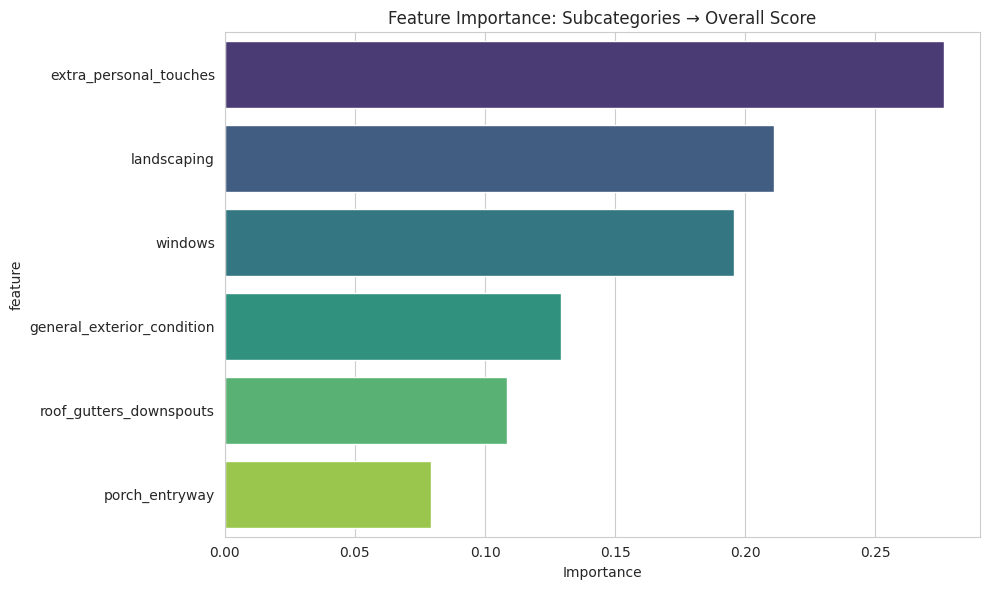

In [42]:
# Feature importance (for Random Forest)
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("📊 Feature Importance (Random Forest):")
    display(feature_importance)
    
    # Visualize
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
    plt.title('Feature Importance: Subcategories → Overall Score')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
